In [33]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.src import backend

In [34]:

def load_batch(fpath, label_key="labels"):
    """Internal utility for parsing CIFAR data.

    Args:
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.

    Returns:
        A tuple `(data, labels)`.
    """
    with open(fpath, "rb") as f:
        d = pickle.load(f, encoding="bytes")
        # decode utf8
        d_decoded = {}
        for k, v in d.items():
            d_decoded[k.decode("utf8")] = v
        d = d_decoded
    data = d["data"]
    labels = d[label_key]

    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels

In [35]:
def load_data_keras():
    num_train_samples = 50000

    x_train = np.empty((num_train_samples, 3, 32, 32), dtype="uint8")
    y_train = np.empty((num_train_samples,), dtype="uint8")
    path = "../Data"
    # batches are within an inner folder
    path = os.path.join(path, "cifar-10-batches-py")
    for i in range(1, 6):
        fpath = os.path.join(path, "data_batch_" + str(i))
        (
            x_train[(i - 1) * 10000 : i * 10000, :, :, :],
            y_train[(i - 1) * 10000 : i * 10000],
        ) = load_batch(fpath)

    fpath = os.path.join(path, "test_batch")
    x_test, y_test = load_batch(fpath)

    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))

    if backend.image_data_format() == "channels_last":
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)

    x_test = x_test.astype(x_train.dtype)
    y_test = y_test.astype(y_train.dtype)

    return (x_train, y_train), (x_test, y_test)

In [45]:
(x_train, y_train), (x_test, y_test) = load_data_keras()

In [37]:
x_train.shape

(50000, 32, 32, 3)

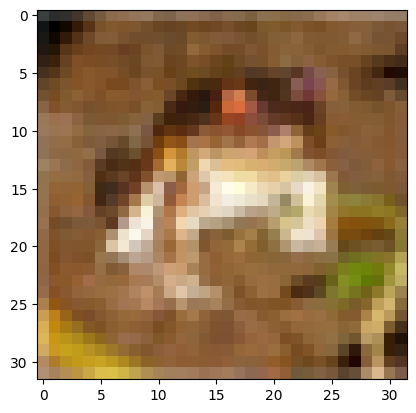

In [38]:
# Check that it's actuall images
plt.imshow(x_train[0])

In [40]:
# Normalize data
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

# Create model
model = tf.keras.models.Sequential()

# Add layers
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

# Layer
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10))
# Output layer
# apply logistic regression

# Train the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, shuffle=True, epochs=100)

'''
I use a MacBook Pro, so I stopped the training after 4 epochs (100 epochs was going to take around 6 hours)
Epoch 1/100
50000/50000 [==============================] - 221s 4ms/step - loss: 1.8571 - acc: 0.3043
Epoch 2/100
50000/50000 [==============================] - 246s 5ms/step - loss: 1.4137 - acc: 0.4910
Epoch 3/100
50000/50000 [==============================] - 236s 5ms/step - loss: 1.1943 - acc: 0.5744
Epoch 4/100
50000/50000 [==============================] - 238s 5ms/step - loss: 1.0693 - acc: 0.6186
Epoch 5/100
 7296/50000 [===>..........................] - ETA: 3:31 - loss: 1.0180 - acc: 0.6419
'''

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
 54/391 ━━━━━━━━━━━━━━━━━━━━ 25s 77ms/step - accuracy: 0.1082 - loss: 3.2888

KeyboardInterrupt: 

In [ ]:
# Evaluate model
val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

In [46]:
# Define feature extraction model
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-2].output)

# Extract features
train_features = feature_extractor.predict(x_train)
test_features = feature_extractor.predict(x_test)


 345/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step

KeyboardInterrupt: 

In [44]:
train_features

array([[0.        , 0.14837186, 0.09104067, ..., 0.        , 0.23924248,
        0.35407493],
       [0.        , 0.1330589 , 0.07487679, ..., 0.        , 0.21733117,
        0.31227103],
       [0.        , 0.14392328, 0.00305479, ..., 0.        , 0.167064  ,
        0.24526204],
       ...,
       [0.        , 0.14322634, 0.00733408, ..., 0.        , 0.16779539,
        0.2434703 ],
       [0.        , 0.12463379, 0.05246085, ..., 0.        , 0.18670967,
        0.2652084 ],
       [0.        , 0.1214411 , 0.06086461, ..., 0.        , 0.17615035,
        0.24662769]], dtype=float32)